In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index
from mofapy2.run.entry_point import entry_point

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph


torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
print(f'Importing data---------------------------------------->')

# Load data with correct index
expression_data_scaled = pd.read_csv("../Updated_model_nd_dataset/expression_data_scaled_FXS_MOFA_3Omics.csv", index_col=0)
methylation_scaled = pd.read_csv("../Updated_model_nd_dataset/methylation_scaled_FXS_MOFA_3Omics.csv", index_col=0)
copy_number_scaled = pd.read_csv("../Updated_model_nd_dataset/copy_number_scaled_FXS_MOFA_3Omics.csv", index_col=0)
subtype_encoded = pd.read_csv("../Updated_model_nd_dataset/subtype_encoded_FXS_MOFA_3Omics.csv", index_col=0)
phenotype_data_clean = pd.read_csv("../Updated_model_nd_dataset/phenotype_data_clean_FXS_MOFA_3Omics.csv", index_col=0)

# Now, index should be sample IDs for all
common_samples = list(set(expression_data_scaled.T.index) & set(methylation_scaled.T.index) & set(copy_number_scaled.T.index) & set(subtype_encoded.index) & set(phenotype_data_clean.index))

print("Expression:", expression_data_scaled.shape)
print("Methylation:", methylation_scaled.shape)
print("Copy Number:", copy_number_scaled.shape)
print("Phenotype:", phenotype_data_clean.shape)
print("Subtype labels:", subtype_encoded.shape)
print("Common samples:", len(common_samples))

Importing data---------------------------------------->
Expression: (60660, 210)
Methylation: (221087, 210)
Copy Number: (55930, 210)
Phenotype: (210, 78)
Subtype labels: (210, 1)
Common samples: 210
Expression: (60660, 210)
Methylation: (221087, 210)
Copy Number: (55930, 210)
Phenotype: (210, 78)
Subtype labels: (210, 1)
Common samples: 210


In [3]:
data_list = [
    [expression_data_scaled.T.values],   
    [methylation_scaled.T.values],       
    [copy_number_scaled.T.values]       
]

# Initialise MOFA
ent = entry_point()
ent.set_data_options(scale_views=False)
ent.set_data_matrix(data_list)

ent.set_model_options(
    factors=16,
    spikeslab_weights=True,
    ard_factors=True,
    ard_weights=True
)

# Training options
ent.set_train_options(
    iter=25,
    convergence_mode="medium",
    seed=42,
    verbose=True
)

# Build and run
ent.build()
ent.run()

# Extract results
factors = ent.model.nodes["Z"].getExpectation()
weights = ent.model.nodes["W"].getExpectation()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group

Factors shape (210, 16)
Weights shape (view0): (60660, 16)
Weights shape (view1): (221087, 16)
Weights shape (view2): (55930, 16)



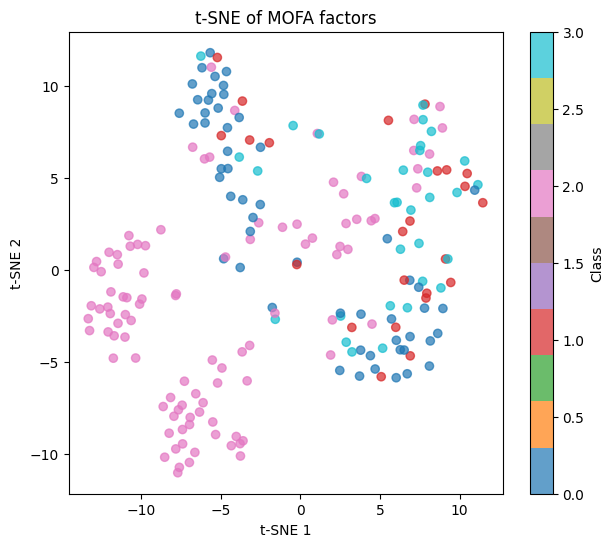

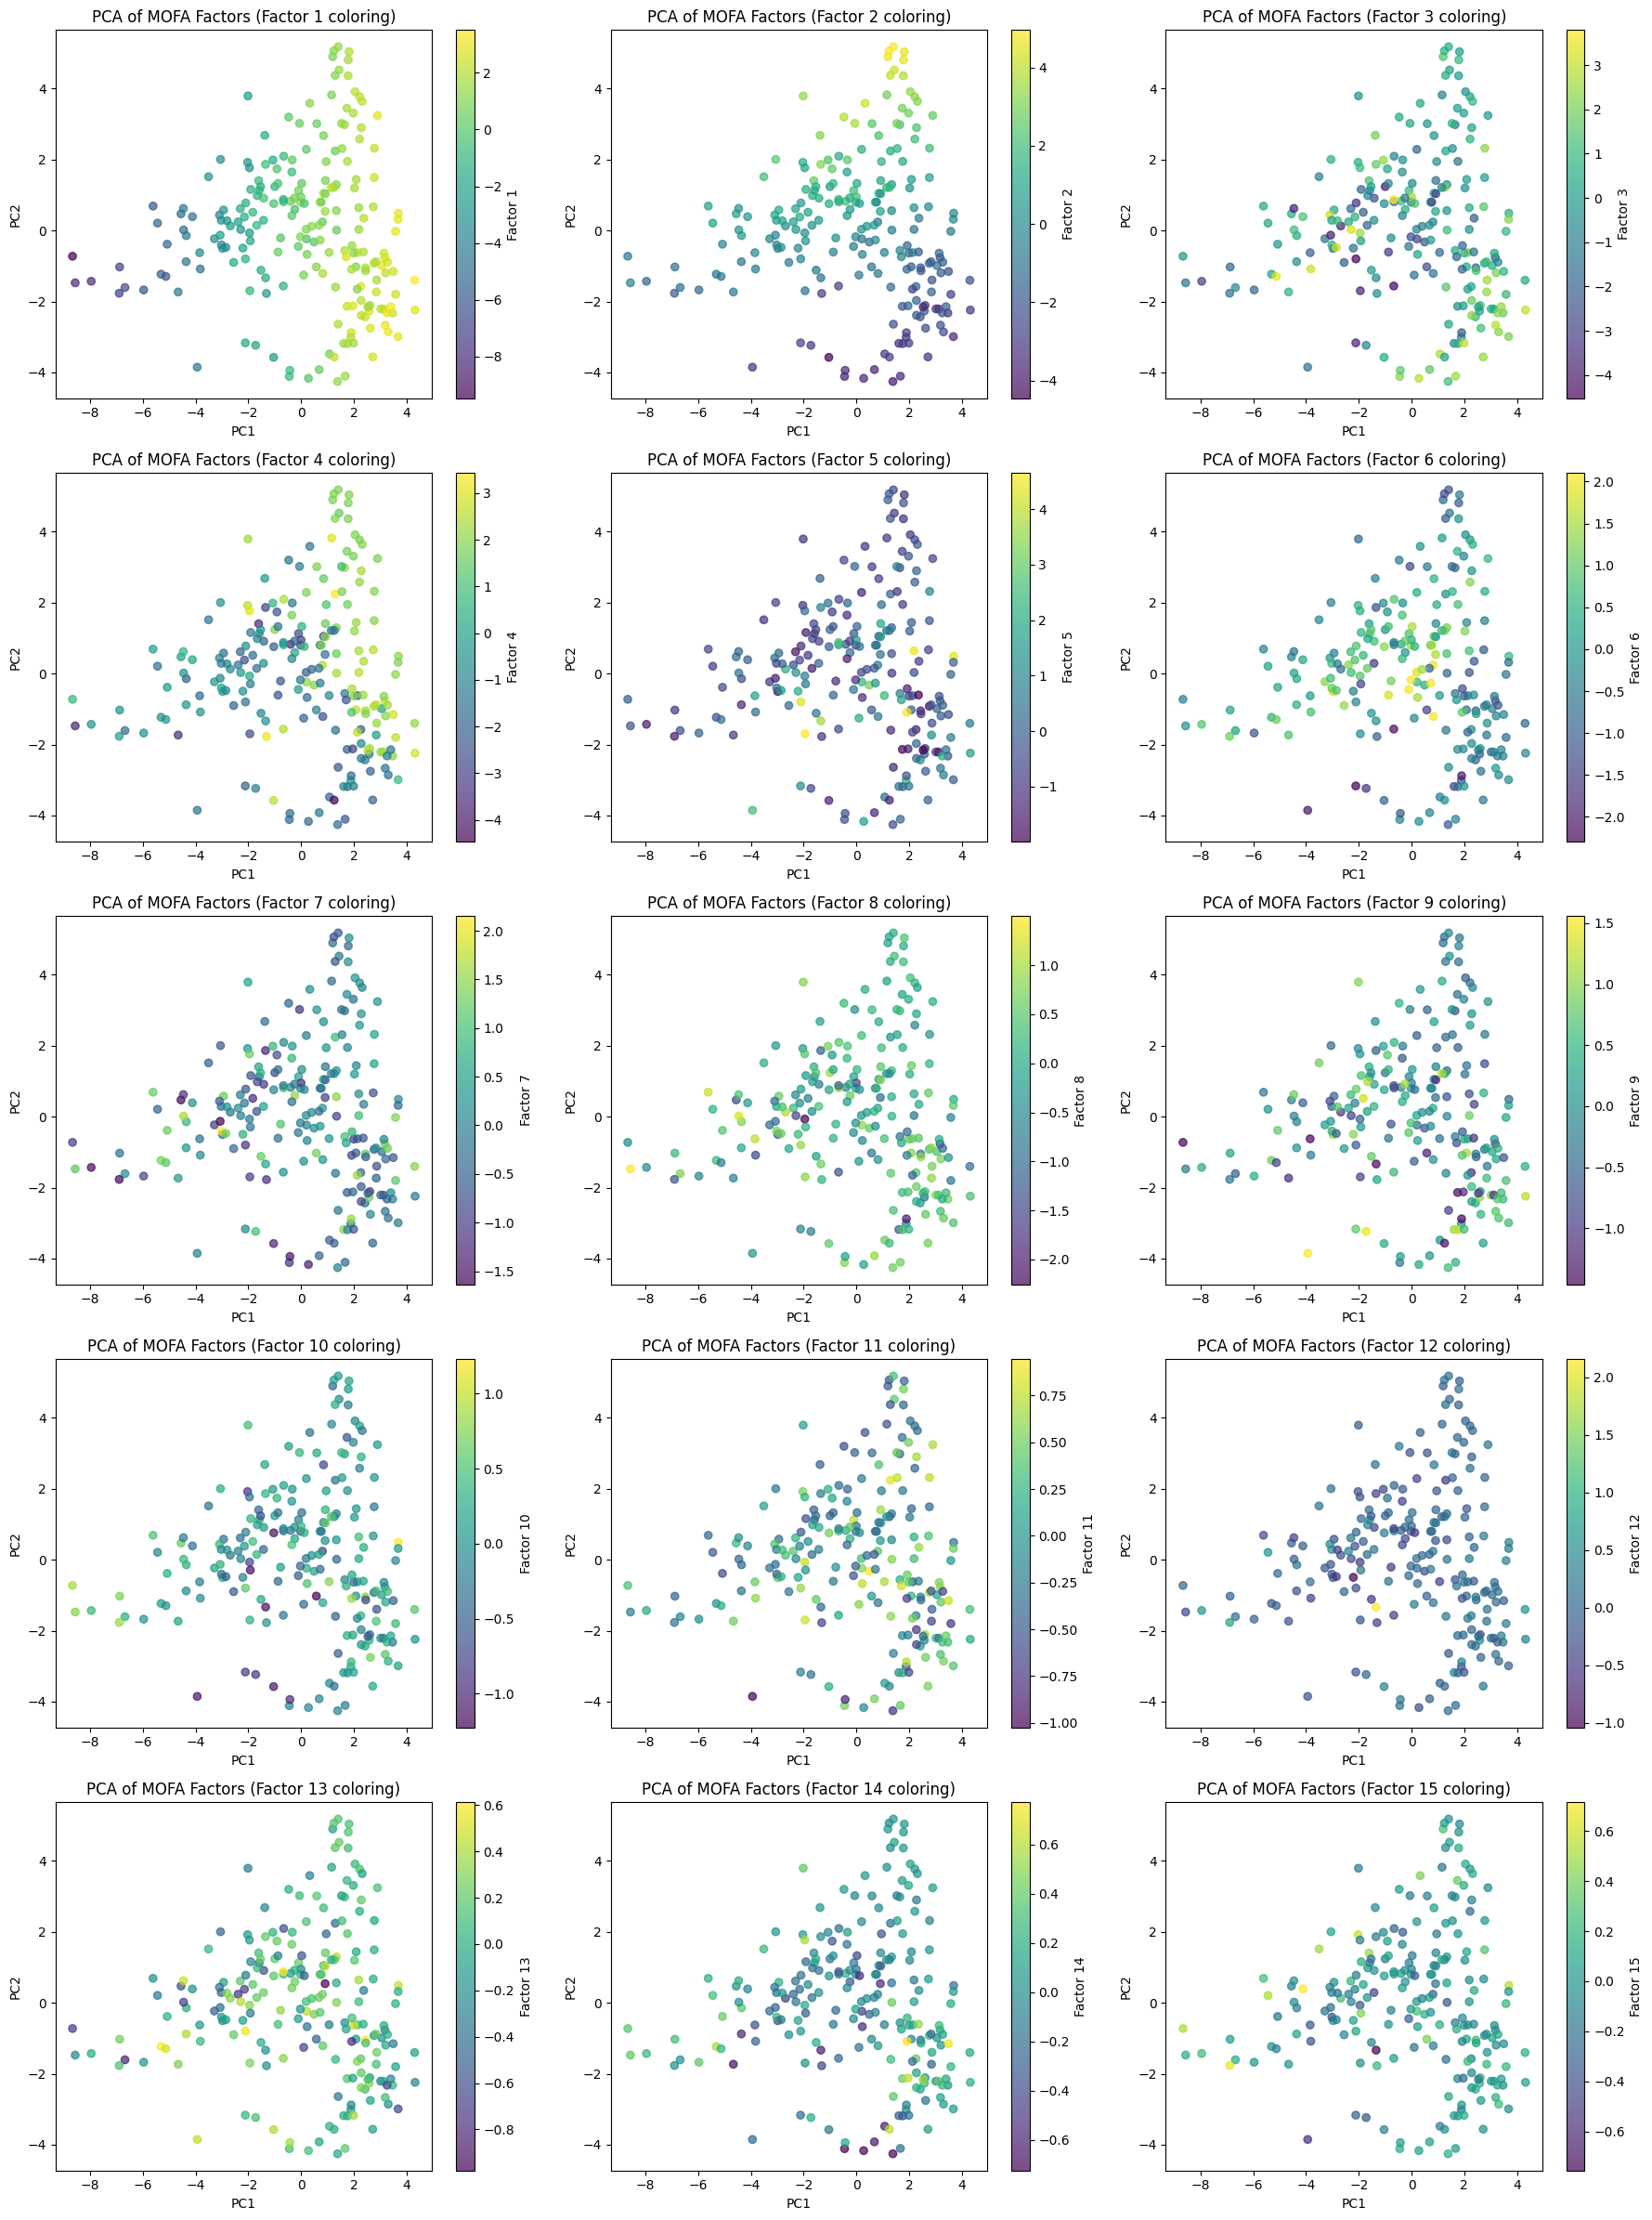

In [4]:
print("Factors shape",factors.shape)
print("Weights shape (view0):", weights[0].shape)
print("Weights shape (view1):", weights[1].shape)
print("Weights shape (view2):", weights[2].shape)
print()


tsne = TSNE(n_components=2, random_state=42)
factors_2d = tsne.fit_transform(factors)

plt.figure(figsize=(7,6))
plt.scatter(factors_2d[:,0], factors_2d[:,1], c=subtype_encoded.values, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of MOFA factors")
plt.colorbar(label="Class")
plt.show()

print()

# factors: (n_samples, n_factors)
factors_array = np.array(factors)
labels = subtype_encoded.loc[common_samples].values

pca = PCA(n_components=2)

fig, axes = plt.subplots(5, 3, figsize=(18, 24))
axes = axes.flatten()

for i in range(15):
    # For each factor, use all factors for PCA, but color by the i-th factor
    pca_result = pca.fit_transform(factors_array)
    ax = axes[i]
    scatter = ax.scatter(pca_result[:,0], pca_result[:,1], c=factors_array[:,i], cmap='viridis', alpha=0.7)
    ax.set_title(f'PCA of MOFA Factors (Factor {i+1} coloring)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax, label=f'Factor {i+1}')

plt.tight_layout()
plt.show()

Adjusted Rand Index (ARI): 0.2809
Normalized Mutual Information (NMI): 0.2972


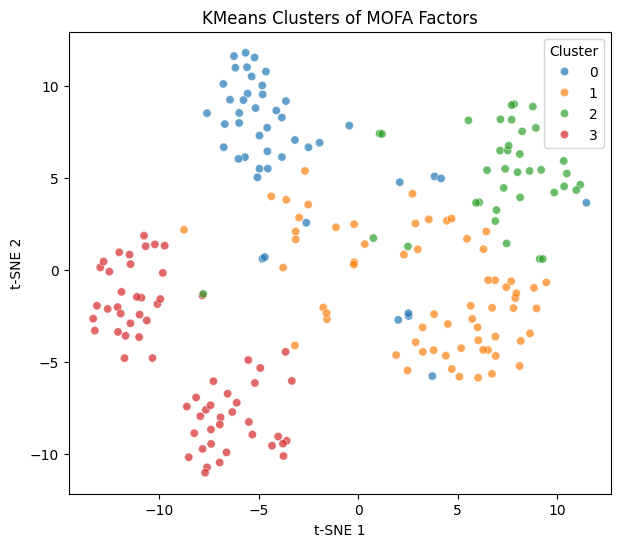

In [5]:
# factors: (n_samples, n_factors)
# subtype_encoded: DataFrame with sample IDs as index, subtype as column

n_clusters = len(np.unique(subtype_encoded.values))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(factors)

# ARI and NMI for clustering quality
true_labels = subtype_encoded.values.ravel()
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Visualize clusters in 2D (t-SNE)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
factors_2d = tsne.fit_transform(factors)

plt.figure(figsize=(7,6))
sns.scatterplot(x=factors_2d[:,0], y=factors_2d[:,1], hue=cluster_labels, palette="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("KMeans Clusters of MOFA Factors")
plt.legend(title="Cluster")
plt.show()

# Deep Neural Network Models

### Auto encoder

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
        )
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


### MultiLayer Perceptions

In [24]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU()
        )
        self.classifier = nn.Linear(128, num_classes)
        
    def forward(self, x):
        embeddings = self.embedding(x)
        output = self.classifier(embeddings)
        return output
    
    def get_embeddings(self, x):
        """Extract embeddings from the hidden layer"""
        return self.embedding(x)

# Fusion matrix

In [35]:
# Function to handle scaling, splitting, and tensor conversion
def prepare_data(factors_scaled, subtype_encoded, device):
    
    X_train, X_test, y_train, y_test = train_test_split(
        factors_scaled, subtype_encoded.values.ravel(), test_size=0.2, random_state=42, stratify=subtype_encoded.values.ravel()
    )
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    return X_train, X_test, y_train, y_test, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

scaler = StandardScaler()
factors_scaled1 = scaler.fit_transform(factors)
factors_scaled2 = np.array(factors)

# Prepare different data variants for comparison
data_variants = {}
data_variants['fusion_standardized_ae'] = prepare_data(factors_scaled1, subtype_encoded, device)
data_variants['fusion_raw_ae'] = prepare_data(factors_scaled2, subtype_encoded, device)

# Add additional MLP variants for embedding-based ML models
data_variants['fusion_standardized_mlp_embed'] = prepare_data(factors_scaled1, subtype_encoded, device)
data_variants['fusion_raw_mlp_embed'] = prepare_data(factors_scaled2, subtype_encoded, device)

In [36]:
# Function to train autoencoder and return latent features and labels
def train_autoencoder_and_get_latent(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, input_dim, latent_dim, device, n_epochs, patience):
    model = Autoencoder(input_dim, latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    wait = 0
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        x_recon, z = model(X_train_tensor)
        train_loss = criterion(x_recon, X_train_tensor)
        train_loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            x_recon_val, _ = model(X_test_tensor)
            val_loss = criterion(x_recon_val, X_test_tensor)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f}")
            break
    # Get latent features for train/test
    model.eval()
    with torch.no_grad():
        _, z_train = model(X_train_tensor)
        _, z_test = model(X_test_tensor)
    z_train_np = z_train.cpu().numpy()
    z_test_np = z_test.cpu().numpy()
    y_train_np = y_train_tensor.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

    Z = np.vstack([z_train_np, z_test_np])
    Y = np.concatenate([y_train_np, y_test_np])

    # ---- Dimensionality reduction for plotting ----
    reducers = {
        "PCA": PCA(n_components=2),
        "t-SNE": TSNE(n_components=2, random_state=42, perplexity=30)
    }
    Z_2d = {}
    for name, reducer in reducers.items():
        Z_2d[name] = reducer.fit_transform(Z)

    # ---- Plot side by side ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for ax, (name, coords) in zip(axes, Z_2d.items()):
        scatter = ax.scatter(coords[:, 0], coords[:, 1], c=Y, cmap="tab10", alpha=0.7)
        ax.set_title(f"AE Latent Space ({name})")
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        legend = ax.legend(*scatter.legend_elements(), title="Classes", loc="best")
    plt.tight_layout()
    plt.show()
    
    return z_train_np, y_train_np, z_test_np, y_test_np, model

In [37]:
# Function to train MLP classifier directly on fusion factors and extract embeddings
def train_mlp_classifier_with_embeddings(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, input_dim, num_classes, device, n_epochs, patience):
    model = MLPClassifier(input_dim, num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0.0
    wait = 0
    
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        train_loss = criterion(outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_acc = (predicted == y_train_tensor).float().mean().item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)
            _, predicted = torch.max(val_outputs.data, 1)
            val_acc = (predicted == y_test_tensor).float().mean().item()
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            wait = 0
        else:
            wait += 1
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")
            
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best validation accuracy: {best_val_acc:.4f}")
            break
    
    # Final evaluation and embedding extraction
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        test_outputs = model(X_test_tensor)
        
        # Get embeddings
        train_embeddings = model.get_embeddings(X_train_tensor)
        test_embeddings = model.get_embeddings(X_test_tensor)
        
        # Get predictions and probabilities
        train_probs = F.softmax(train_outputs, dim=1).cpu().numpy()
        test_probs = F.softmax(test_outputs, dim=1).cpu().numpy()
        
        _, train_pred = torch.max(train_outputs, 1)
        _, test_pred = torch.max(test_outputs, 1)
        
        train_pred_np = train_pred.cpu().numpy()
        test_pred_np = test_pred.cpu().numpy()
        
        train_embeddings_np = train_embeddings.cpu().numpy()
        test_embeddings_np = test_embeddings.cpu().numpy()
        
        y_train_np = y_train_tensor.cpu().numpy()
        y_test_np = y_test_tensor.cpu().numpy()
    
    # Visualize MLP embeddings similar to autoencoder
    Z = np.vstack([train_embeddings_np, test_embeddings_np])
    Y = np.concatenate([y_train_np, y_test_np])

    # ---- Dimensionality reduction for plotting ----
    reducers = {
        "PCA": PCA(n_components=2),
        "t-SNE": TSNE(n_components=2, random_state=42, perplexity=30)
    }
    Z_2d = {}
    for name, reducer in reducers.items():
        Z_2d[name] = reducer.fit_transform(Z)

    # ---- Plot side by side ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for ax, (name, coords) in zip(axes, Z_2d.items()):
        scatter = ax.scatter(coords[:, 0], coords[:, 1], c=Y, cmap="tab10", alpha=0.7)
        ax.set_title(f"MLP Embedding Space ({name})")
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        legend = ax.legend(*scatter.legend_elements(), title="Classes", loc="best")
    plt.tight_layout()
    plt.show()
    
    return train_pred_np, y_train_np, test_pred_np, y_test_np, train_probs, test_probs, train_embeddings_np, test_embeddings_np, model

In [38]:
# Function to evaluate MLP model results
def evaluate_mlp_model(test_pred_np, y_test_np, test_probs):
    acc = accuracy_score(y_test_np, test_pred_np)
    f1_macro = f1_score(y_test_np, test_pred_np, average='macro')
    f1_micro = f1_score(y_test_np, test_pred_np, average='micro')
    precision = precision_score(y_test_np, test_pred_np, average='macro')
    recall = recall_score(y_test_np, test_pred_np, average='macro')
    
    try:
        auc = roc_auc_score(y_test_np, test_probs, multi_class='ovr')
    except Exception:
        auc = None
    
    return {
        'acc': acc,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'y_pred': test_pred_np,
        'y_prob': test_probs
    }

In [39]:
# Function to train and evaluate multiple ML classifiers on latent features
def evaluate_ml_models(z_train_np, y_train_np, z_test_np, y_test_np):
    models = {
        'LogisticRegression': LogisticRegression(max_iter=500),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'NaiveBayes': GaussianNB()
    }
    results = {}
    n_classes = len(np.unique(y_test_np))
    for name, clf in models.items():
        clf.fit(z_train_np, y_train_np)
        y_pred = clf.predict(z_test_np)
        if hasattr(clf, 'predict_proba'):
            y_prob = clf.predict_proba(z_test_np)
        else:
            try:
                y_prob = clf.decision_function(z_test_np)
                if y_prob.ndim == 1:
                    y_prob = np.vstack([1-y_prob, y_prob]).T
            except Exception:
                y_prob = None
        acc = accuracy_score(y_test_np, y_pred)
        f1_macro = f1_score(y_test_np, y_pred, average='macro')
        f1_micro = f1_score(y_test_np, y_pred, average='micro')
        precision = precision_score(y_test_np, y_pred, average='macro')
        recall = recall_score(y_test_np, y_pred, average='macro')
        try:
            auc = roc_auc_score(y_test_np, y_prob, multi_class='ovr') if y_prob is not None else None
        except Exception:
            auc = None
        results[name] = {
            'acc': acc,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'precision': precision,
            'recall': recall,
            'auc': auc,
            'y_pred': y_pred,
            'y_prob': y_prob,
            'clf': clf
        }
    return results


--- Training for Data Variant: fusion_standardized_ae ---
Training Autoencoder...
Epoch 5/100, Train Loss: 0.8786, Val Loss: 0.9140
Epoch 10/100, Train Loss: 0.6322, Val Loss: 0.7129
Epoch 15/100, Train Loss: 0.3531, Val Loss: 0.4580
Epoch 20/100, Train Loss: 0.1831, Val Loss: 0.2713
Epoch 25/100, Train Loss: 0.0954, Val Loss: 0.1441
Epoch 30/100, Train Loss: 0.0459, Val Loss: 0.0685
Epoch 35/100, Train Loss: 0.0299, Val Loss: 0.0425
Epoch 40/100, Train Loss: 0.0222, Val Loss: 0.0358
Epoch 45/100, Train Loss: 0.0139, Val Loss: 0.0298
Epoch 50/100, Train Loss: 0.0090, Val Loss: 0.0261
Epoch 55/100, Train Loss: 0.0069, Val Loss: 0.0254
Epoch 60/100, Train Loss: 0.0048, Val Loss: 0.0223
Epoch 65/100, Train Loss: 0.0035, Val Loss: 0.0182
Epoch 70/100, Train Loss: 0.0028, Val Loss: 0.0161
Epoch 75/100, Train Loss: 0.0032, Val Loss: 0.0176
Early stopping at epoch 77. Best validation loss: 0.0158
Epoch 60/100, Train Loss: 0.0048, Val Loss: 0.0223
Epoch 65/100, Train Loss: 0.0035, Val Loss: 0

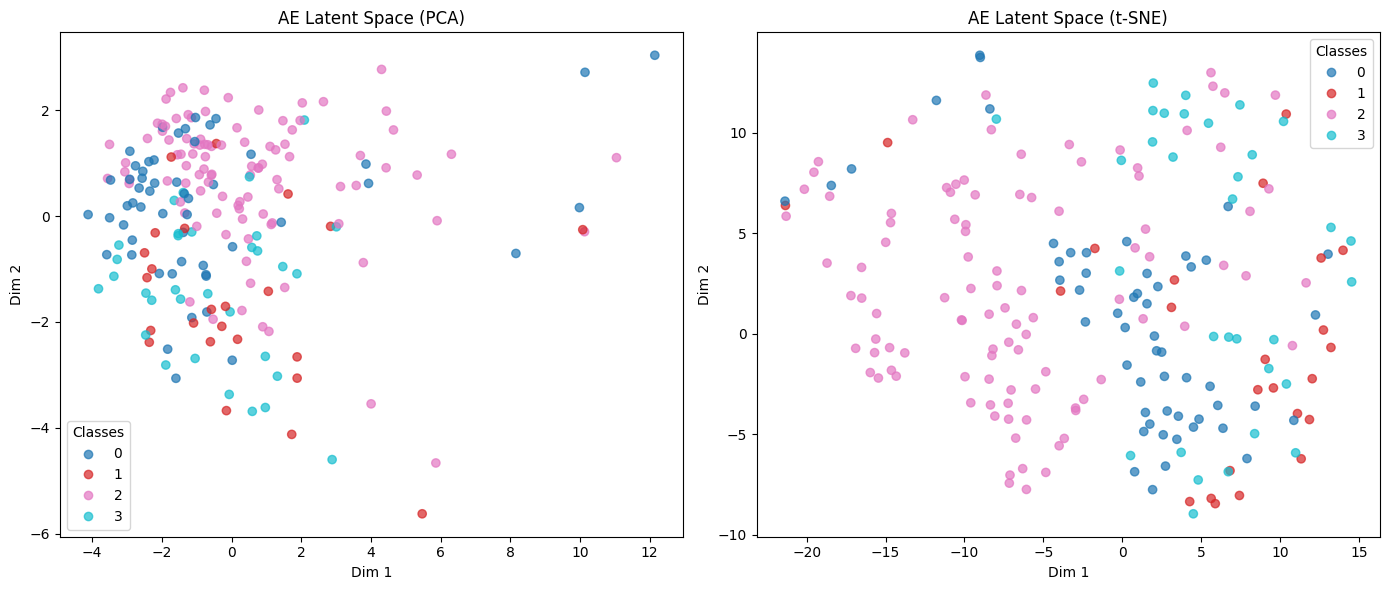


--- Training for Data Variant: fusion_raw_ae ---
Training Autoencoder...
Epoch 5/100, Train Loss: 1.1458, Val Loss: 1.0125
Epoch 10/100, Train Loss: 0.6740, Val Loss: 0.6047
Epoch 15/100, Train Loss: 0.2930, Val Loss: 0.2973
Epoch 20/100, Train Loss: 0.1724, Val Loss: 0.1939
Epoch 25/100, Train Loss: 0.1328, Val Loss: 0.1411
Epoch 30/100, Train Loss: 0.0758, Val Loss: 0.1018
Epoch 35/100, Train Loss: 0.0615, Val Loss: 0.0883
Epoch 40/100, Train Loss: 0.0419, Val Loss: 0.0641
Epoch 45/100, Train Loss: 0.0344, Val Loss: 0.0531
Epoch 50/100, Train Loss: 0.0268, Val Loss: 0.0454
Epoch 55/100, Train Loss: 0.0208, Val Loss: 0.0438
Epoch 60/100, Train Loss: 0.0173, Val Loss: 0.0399
Epoch 65/100, Train Loss: 0.0139, Val Loss: 0.0350
Epoch 70/100, Train Loss: 0.0117, Val Loss: 0.0312
Epoch 75/100, Train Loss: 0.0099, Val Loss: 0.0290
Epoch 80/100, Train Loss: 0.0085, Val Loss: 0.0266
Epoch 85/100, Train Loss: 0.0073, Val Loss: 0.0245
Epoch 90/100, Train Loss: 0.0062, Val Loss: 0.0229
Epoch 95/

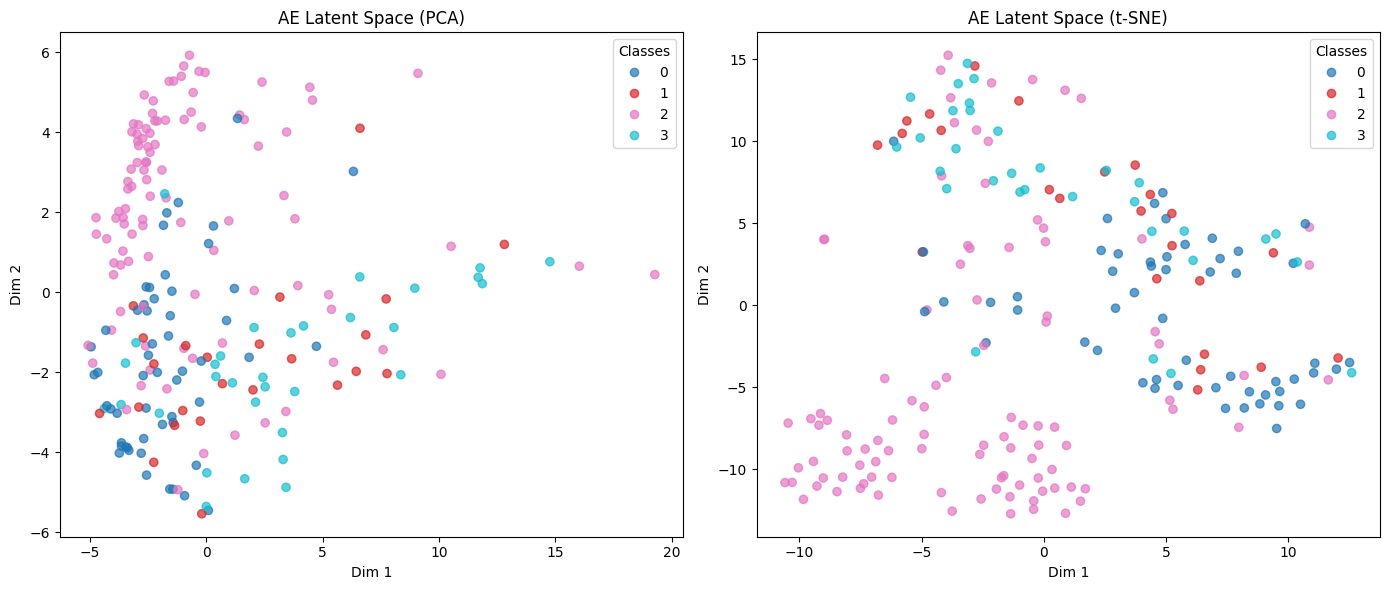


--- Training for Data Variant: fusion_standardized_mlp_embed ---
Training MLP Classifier with Embeddings...
Epoch 10/100, Train Loss: 1.1909, Train Acc: 0.5417, Val Loss: 1.1977, Val Acc: 0.5238
Early stopping at epoch 10. Best validation accuracy: 0.5238


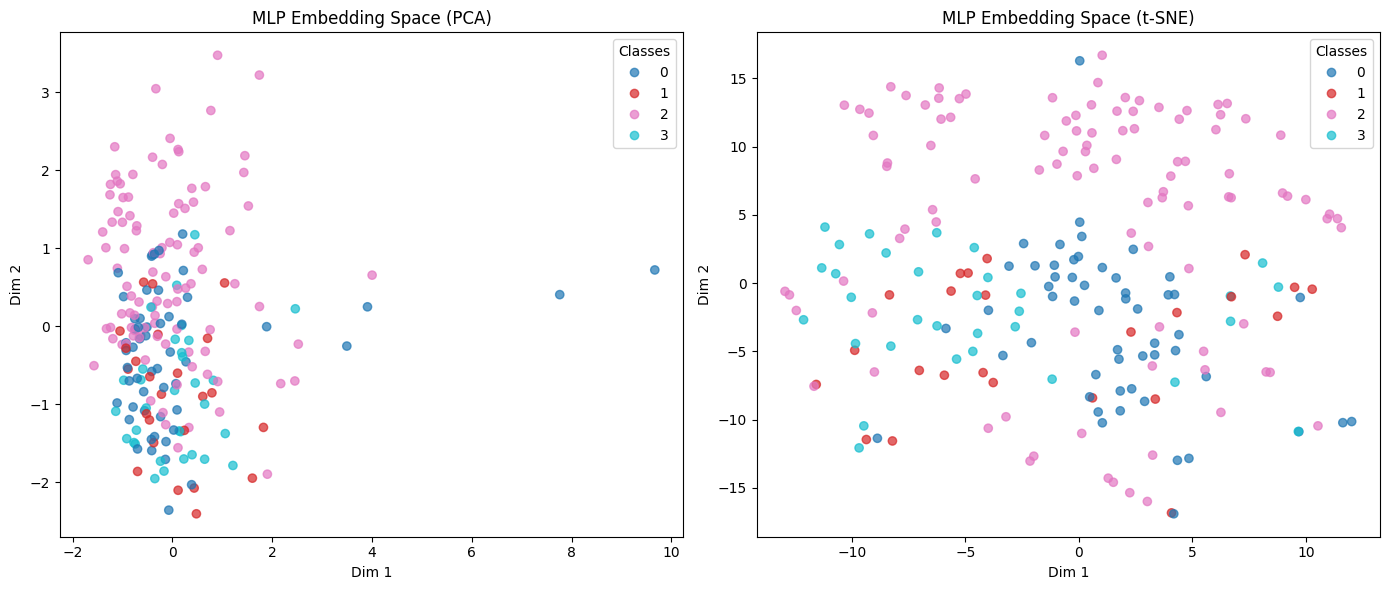

MLP Direct Results - Accuracy: 0.5238, F1-Macro: 0.2464

--- Training for Data Variant: fusion_raw_mlp_embed ---
Training MLP Classifier with Embeddings...
Epoch 10/100, Train Loss: 1.1470, Train Acc: 0.6607, Val Loss: 1.1876, Val Acc: 0.5000
Epoch 20/100, Train Loss: 0.9432, Train Acc: 0.7381, Val Loss: 1.0505, Val Acc: 0.5952
Early stopping at epoch 21. Best validation accuracy: 0.5952


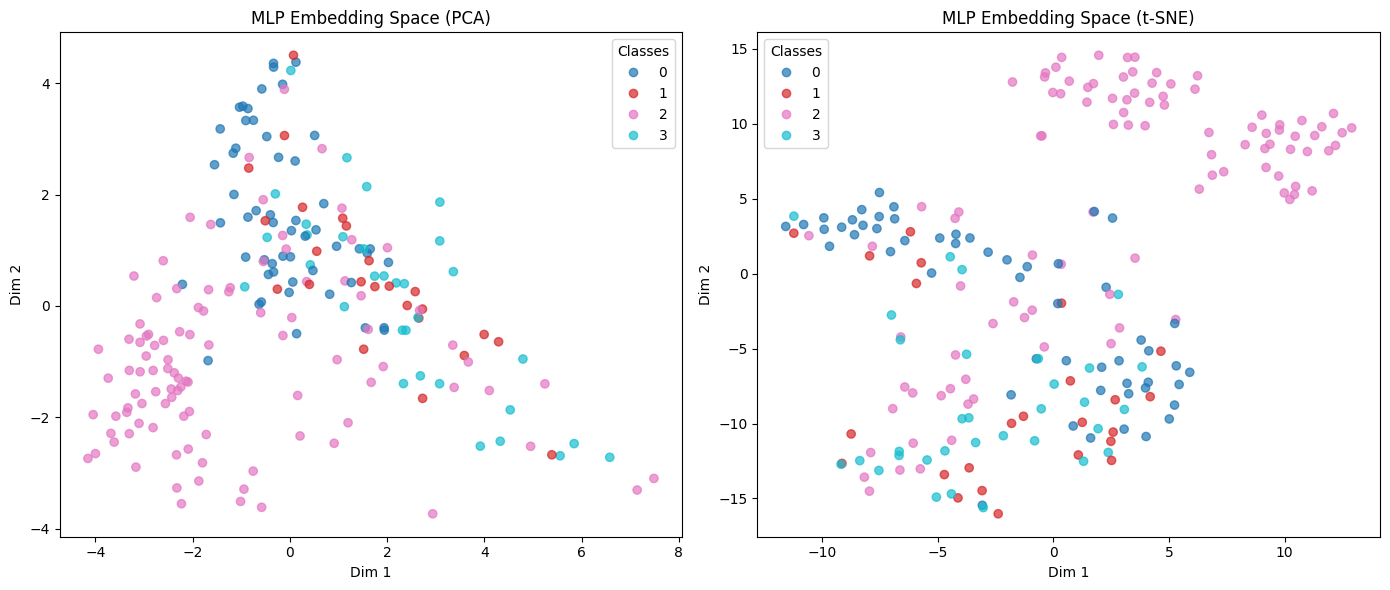

MLP Direct Results - Accuracy: 0.5952, F1-Macro: 0.4160


In [40]:
# Run all data variants, train models, and evaluate
results = {}
latent_dim = 64
n_epochs = 100
patience = 5
num_classes = len(np.unique(subtype_encoded.values))

for variant_name, data in data_variants.items():
    print(f"\n--- Training for Data Variant: {variant_name} ---")
    X_train, X_test, y_train, y_test, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = data
    input_dim = X_train.shape[1]
    
    if 'mlp_embed' in variant_name:
        # Train MLP classifier with embeddings and run ML models on embeddings
        print("Training MLP Classifier with Embeddings...")
        train_pred_np, y_train_np, test_pred_np, y_test_np, train_probs, test_probs, train_embeddings_np, test_embeddings_np, mlp_model = train_mlp_classifier_with_embeddings(
            X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, input_dim, num_classes, device, n_epochs, patience)
        
        # Evaluate MLP model (direct classification)
        mlp_results = evaluate_mlp_model(test_pred_np, y_test_np, test_probs)
        
        # Evaluate ML models on MLP embeddings
        ml_results = evaluate_ml_models(train_embeddings_np, y_train_np, test_embeddings_np, y_test_np)
        
        results[variant_name] = {
            'mlp_results': mlp_results, 
            'ml_results': ml_results, 
            'y_test_np': y_test_np, 
            'model_type': 'mlp_embed'
        }
        
        print(f"MLP Direct Results - Accuracy: {mlp_results['acc']:.4f}, F1-Macro: {mlp_results['f1_macro']:.4f}")
        
    else:
        # Train autoencoder and get latent features
        print("Training Autoencoder...")
        z_train_np, y_train_np, z_test_np, y_test_np, ae_model = train_autoencoder_and_get_latent(
            X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, input_dim, latent_dim, device, n_epochs, patience)
        
        # Evaluate ML models on latent features
        ml_results = evaluate_ml_models(z_train_np, y_train_np, z_test_np, y_test_np)
        results[variant_name] = {'ml_results': ml_results, 'y_test_np': y_test_np, 'model_type': 'autoencoder'}

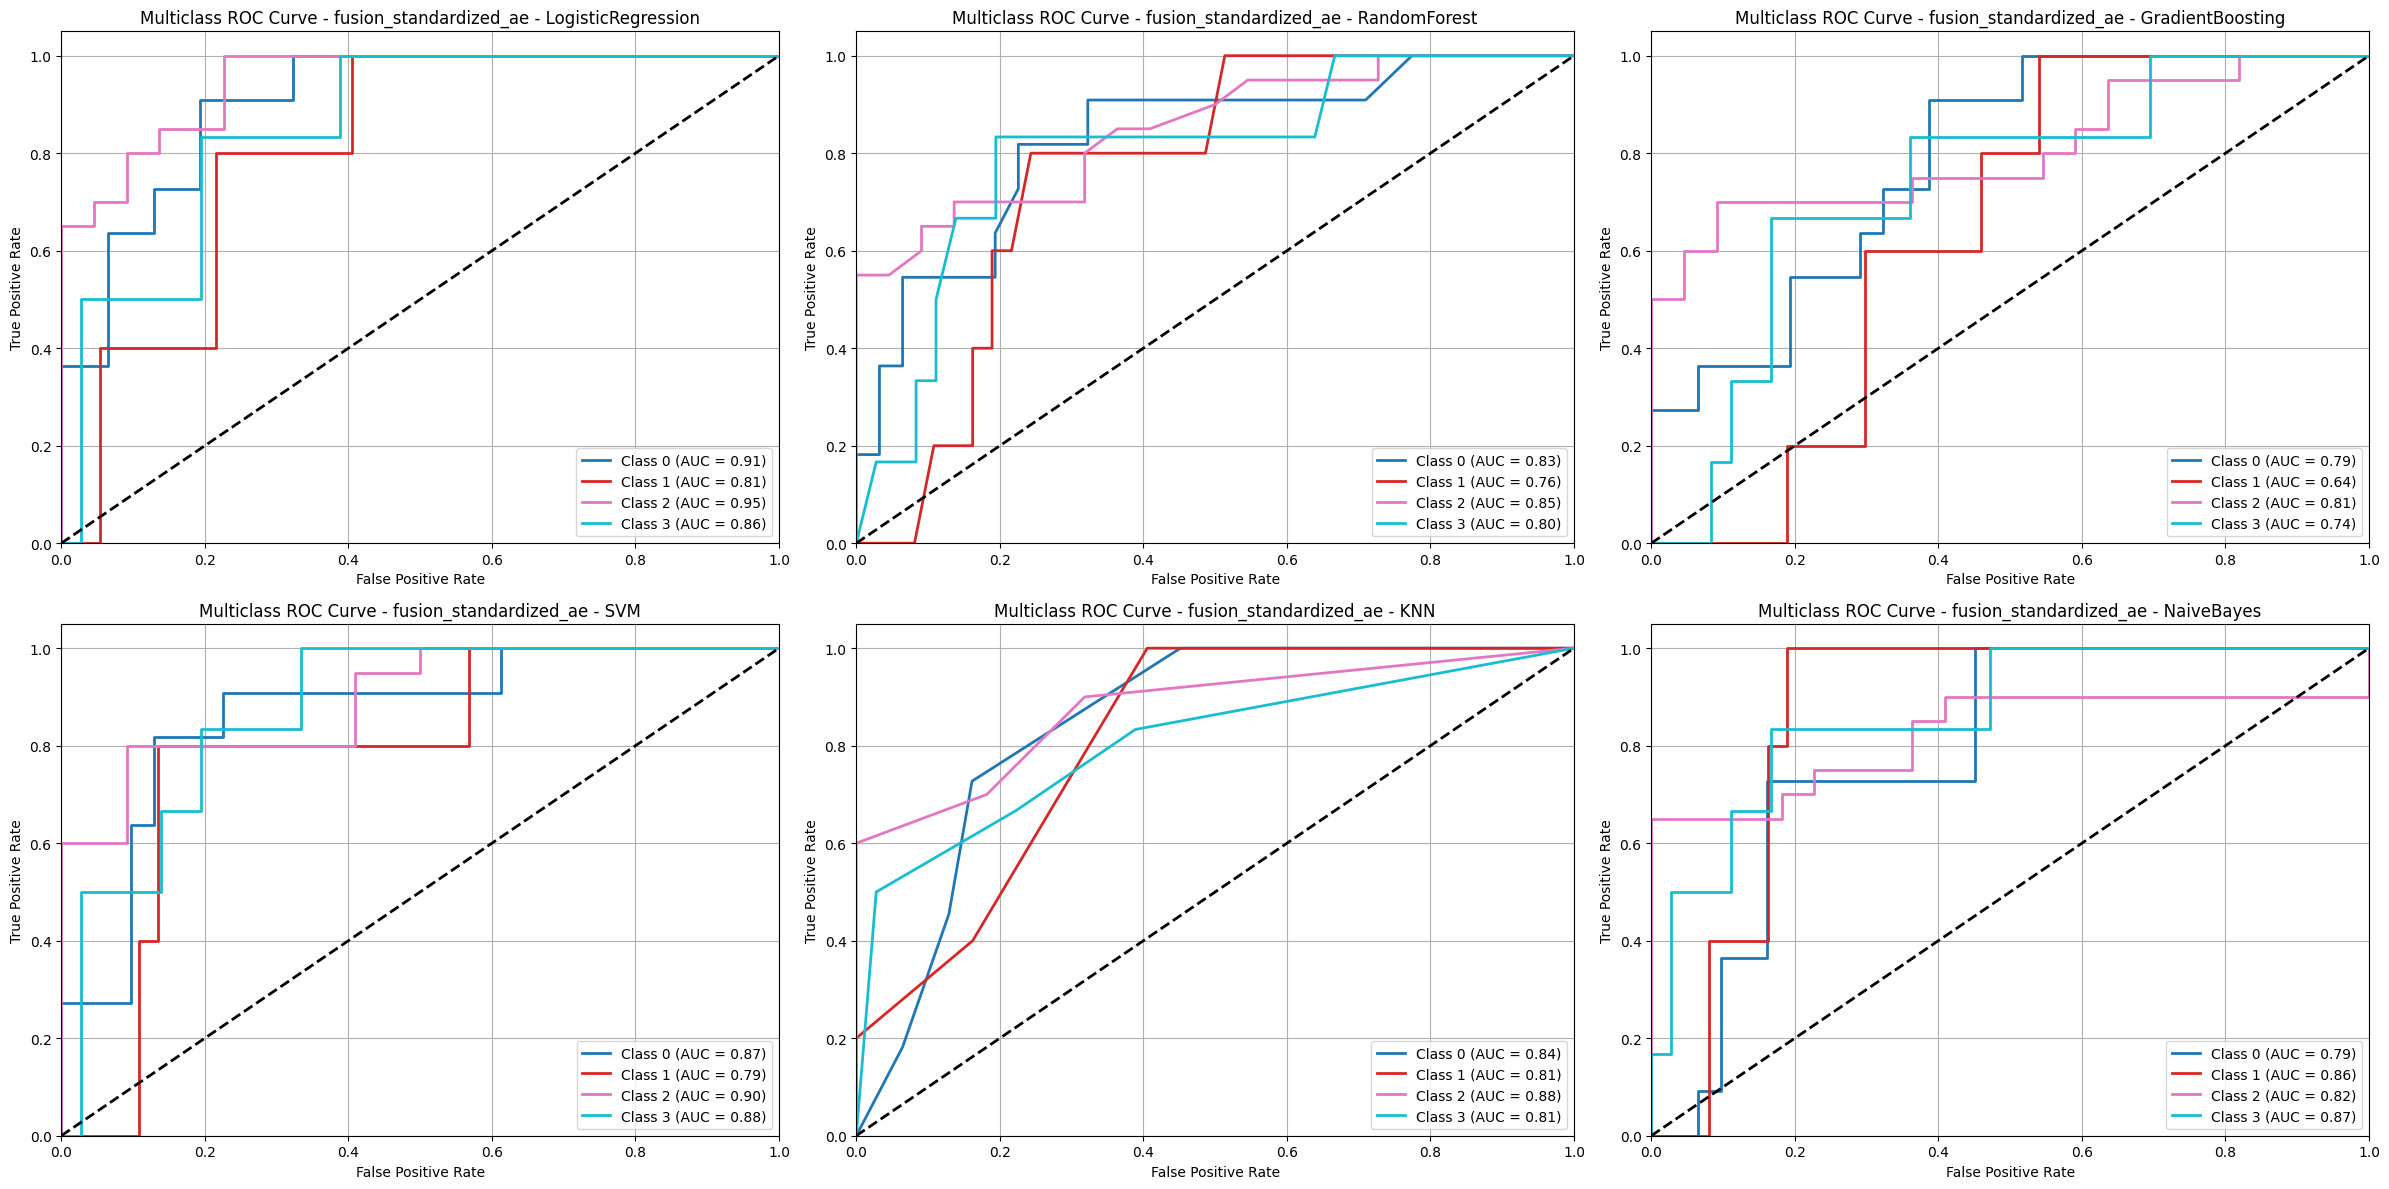

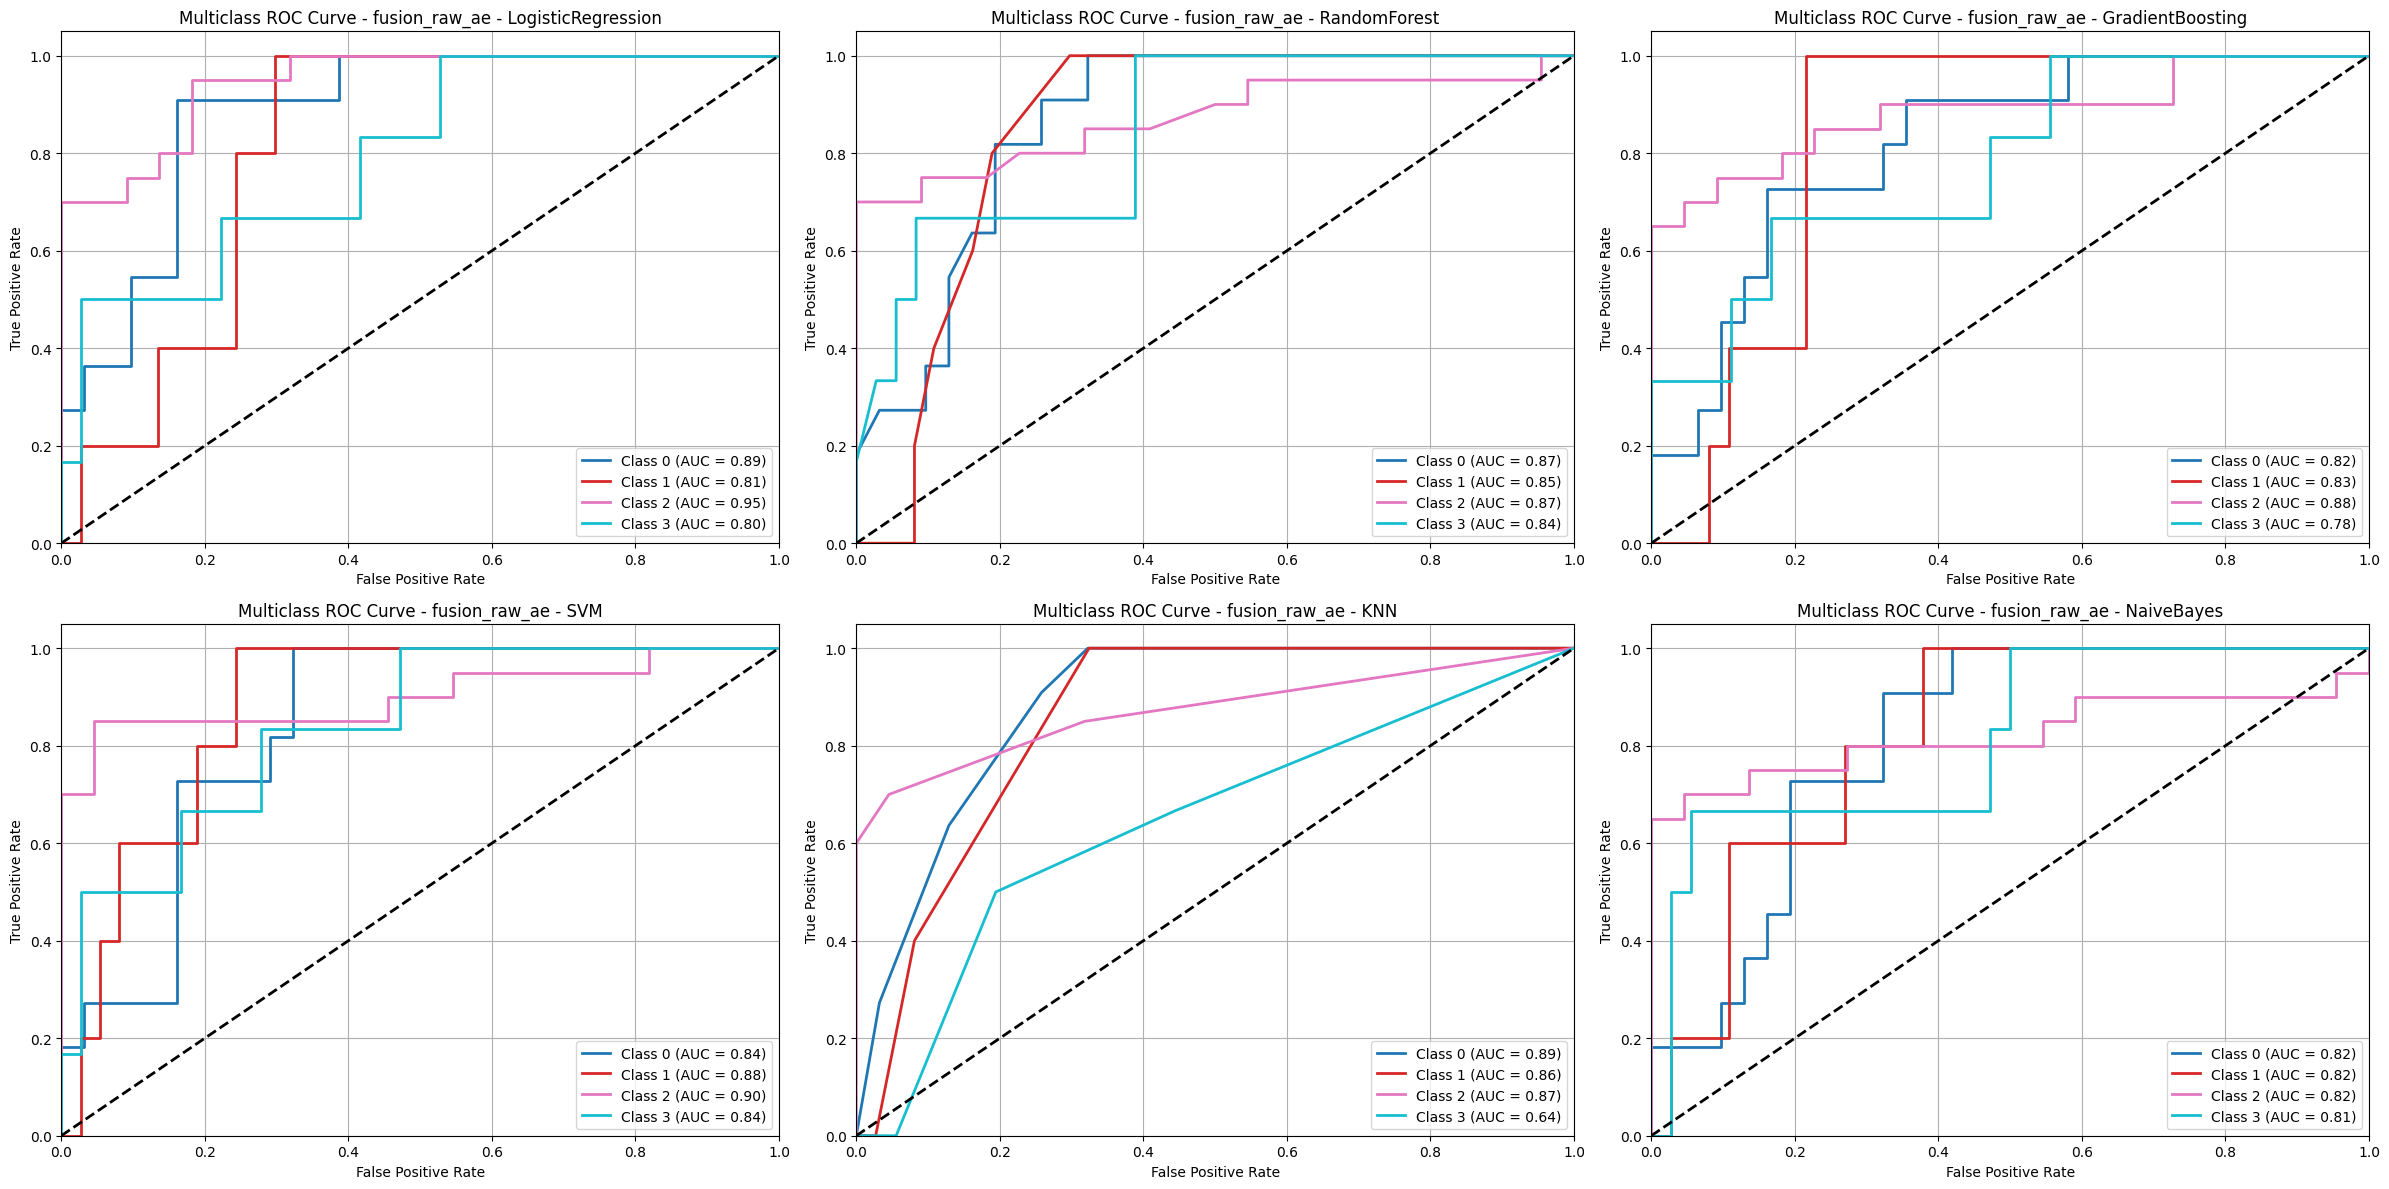

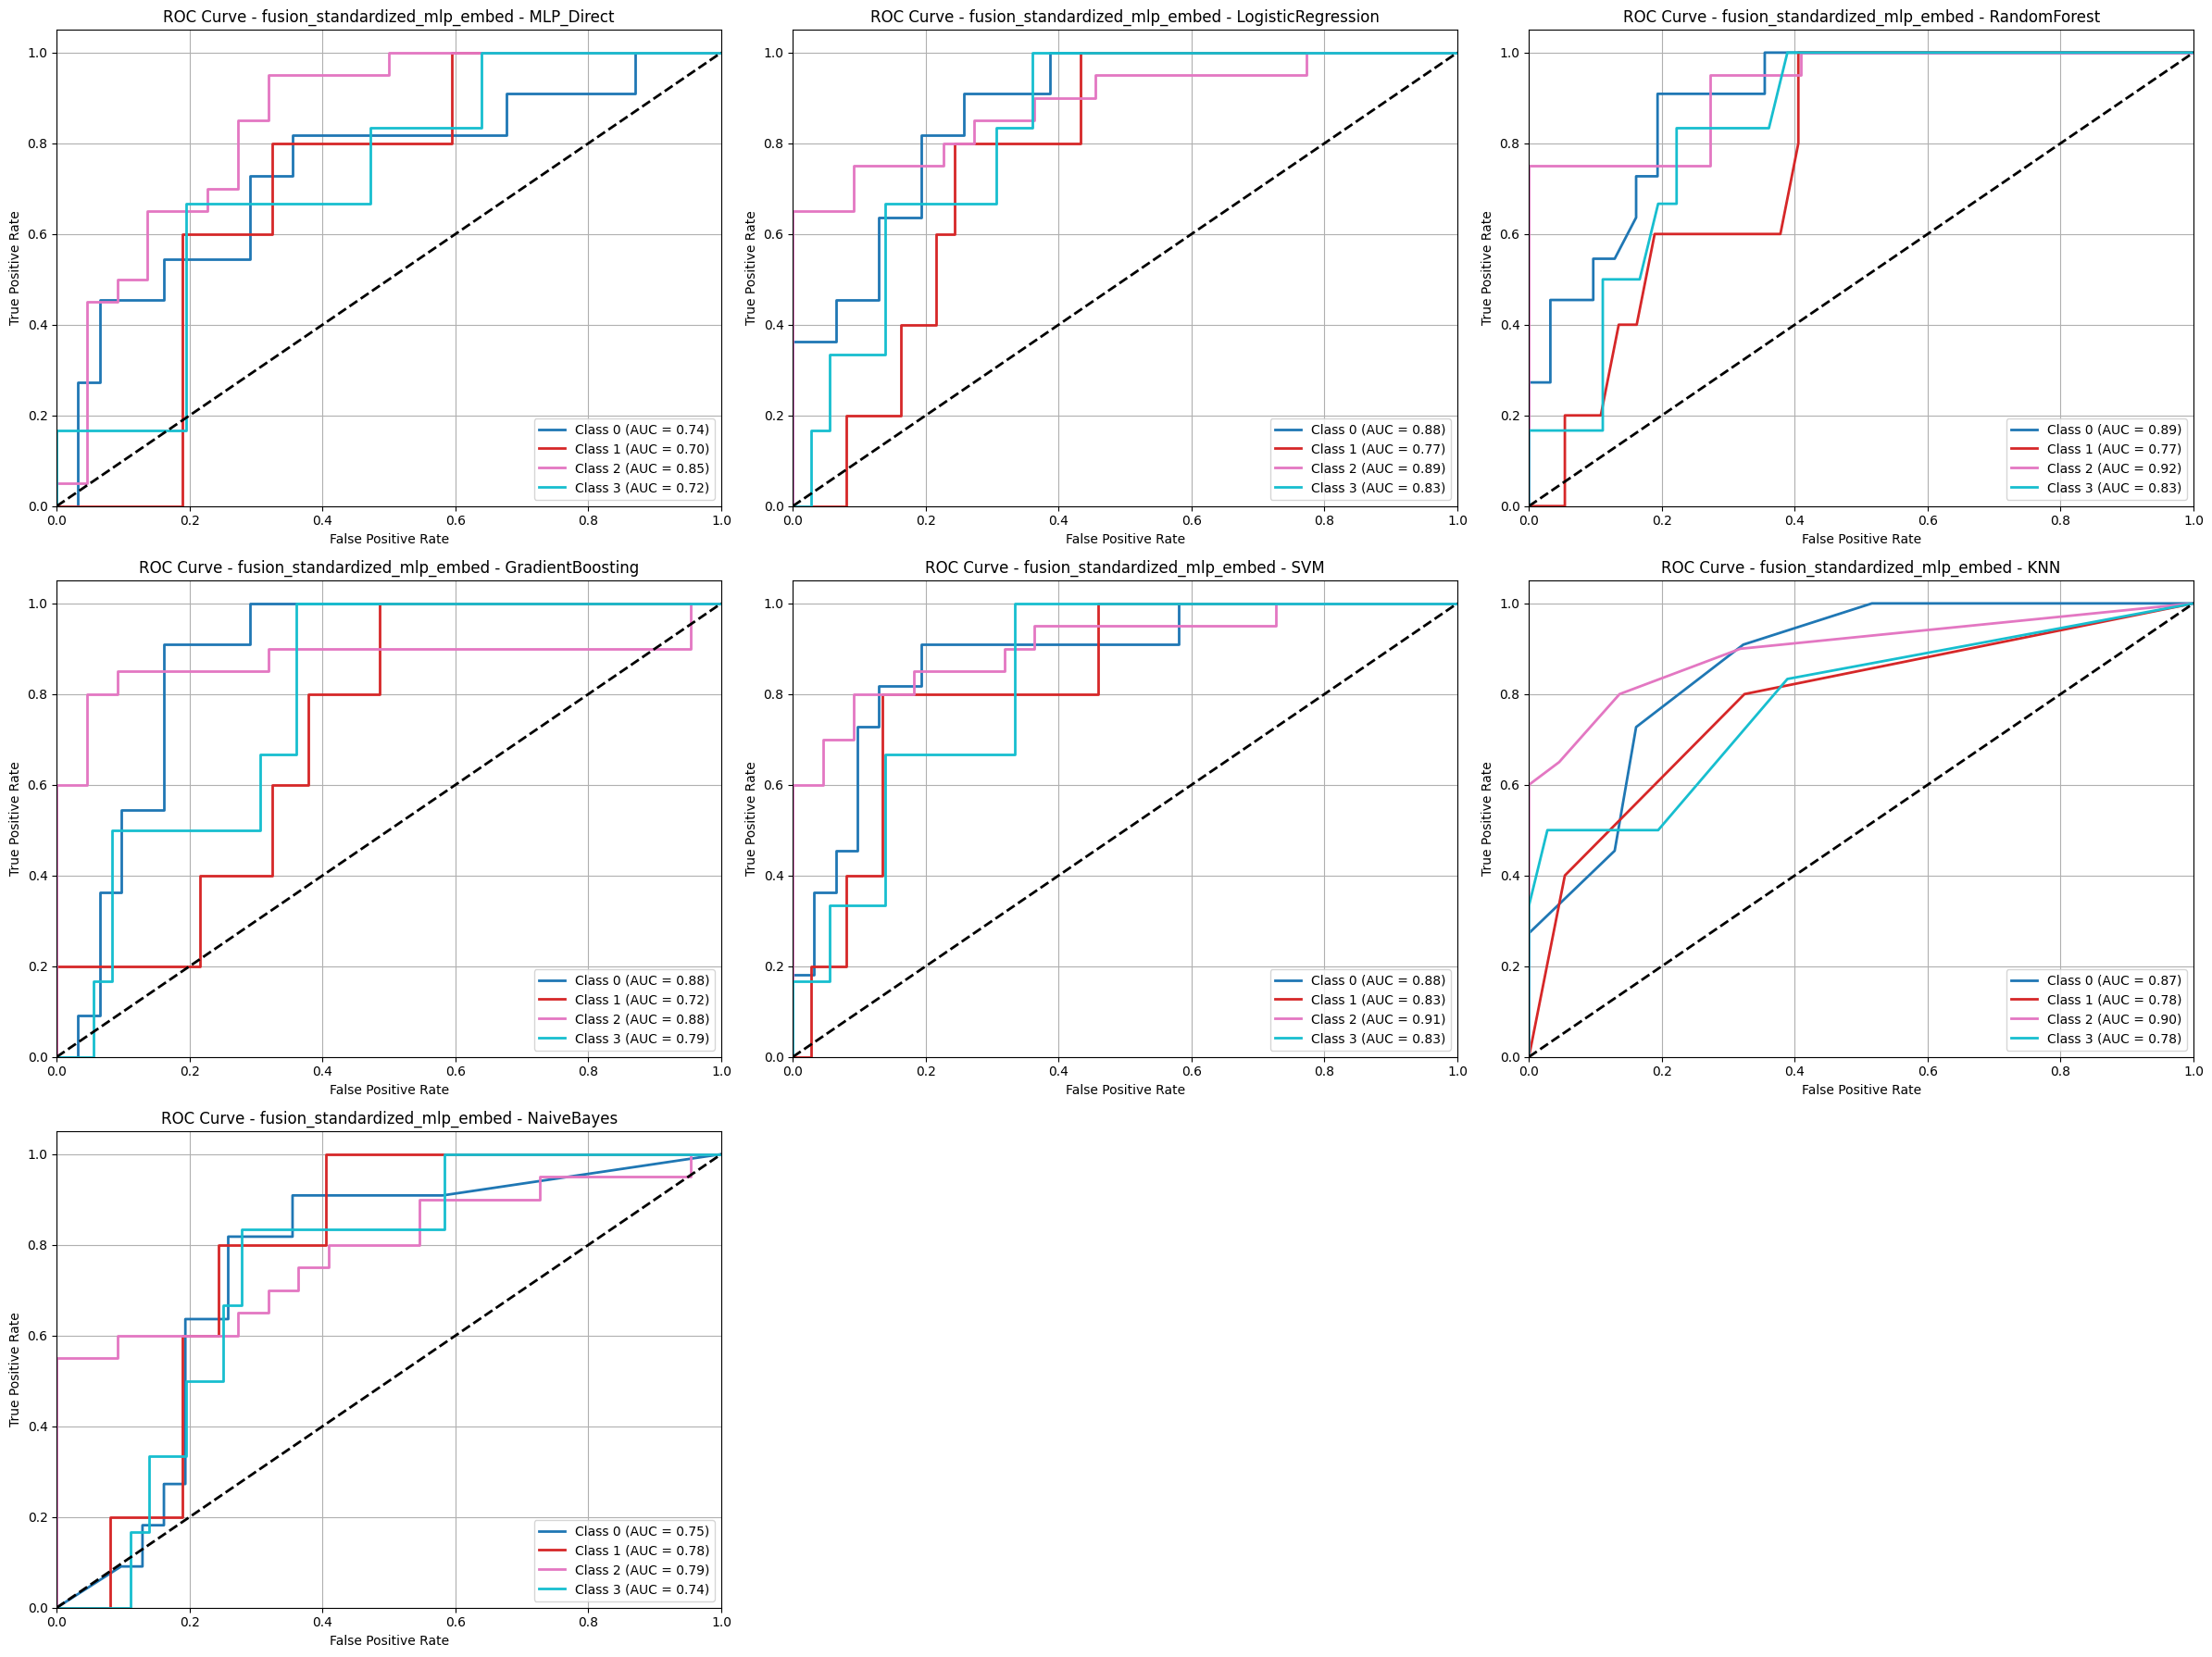

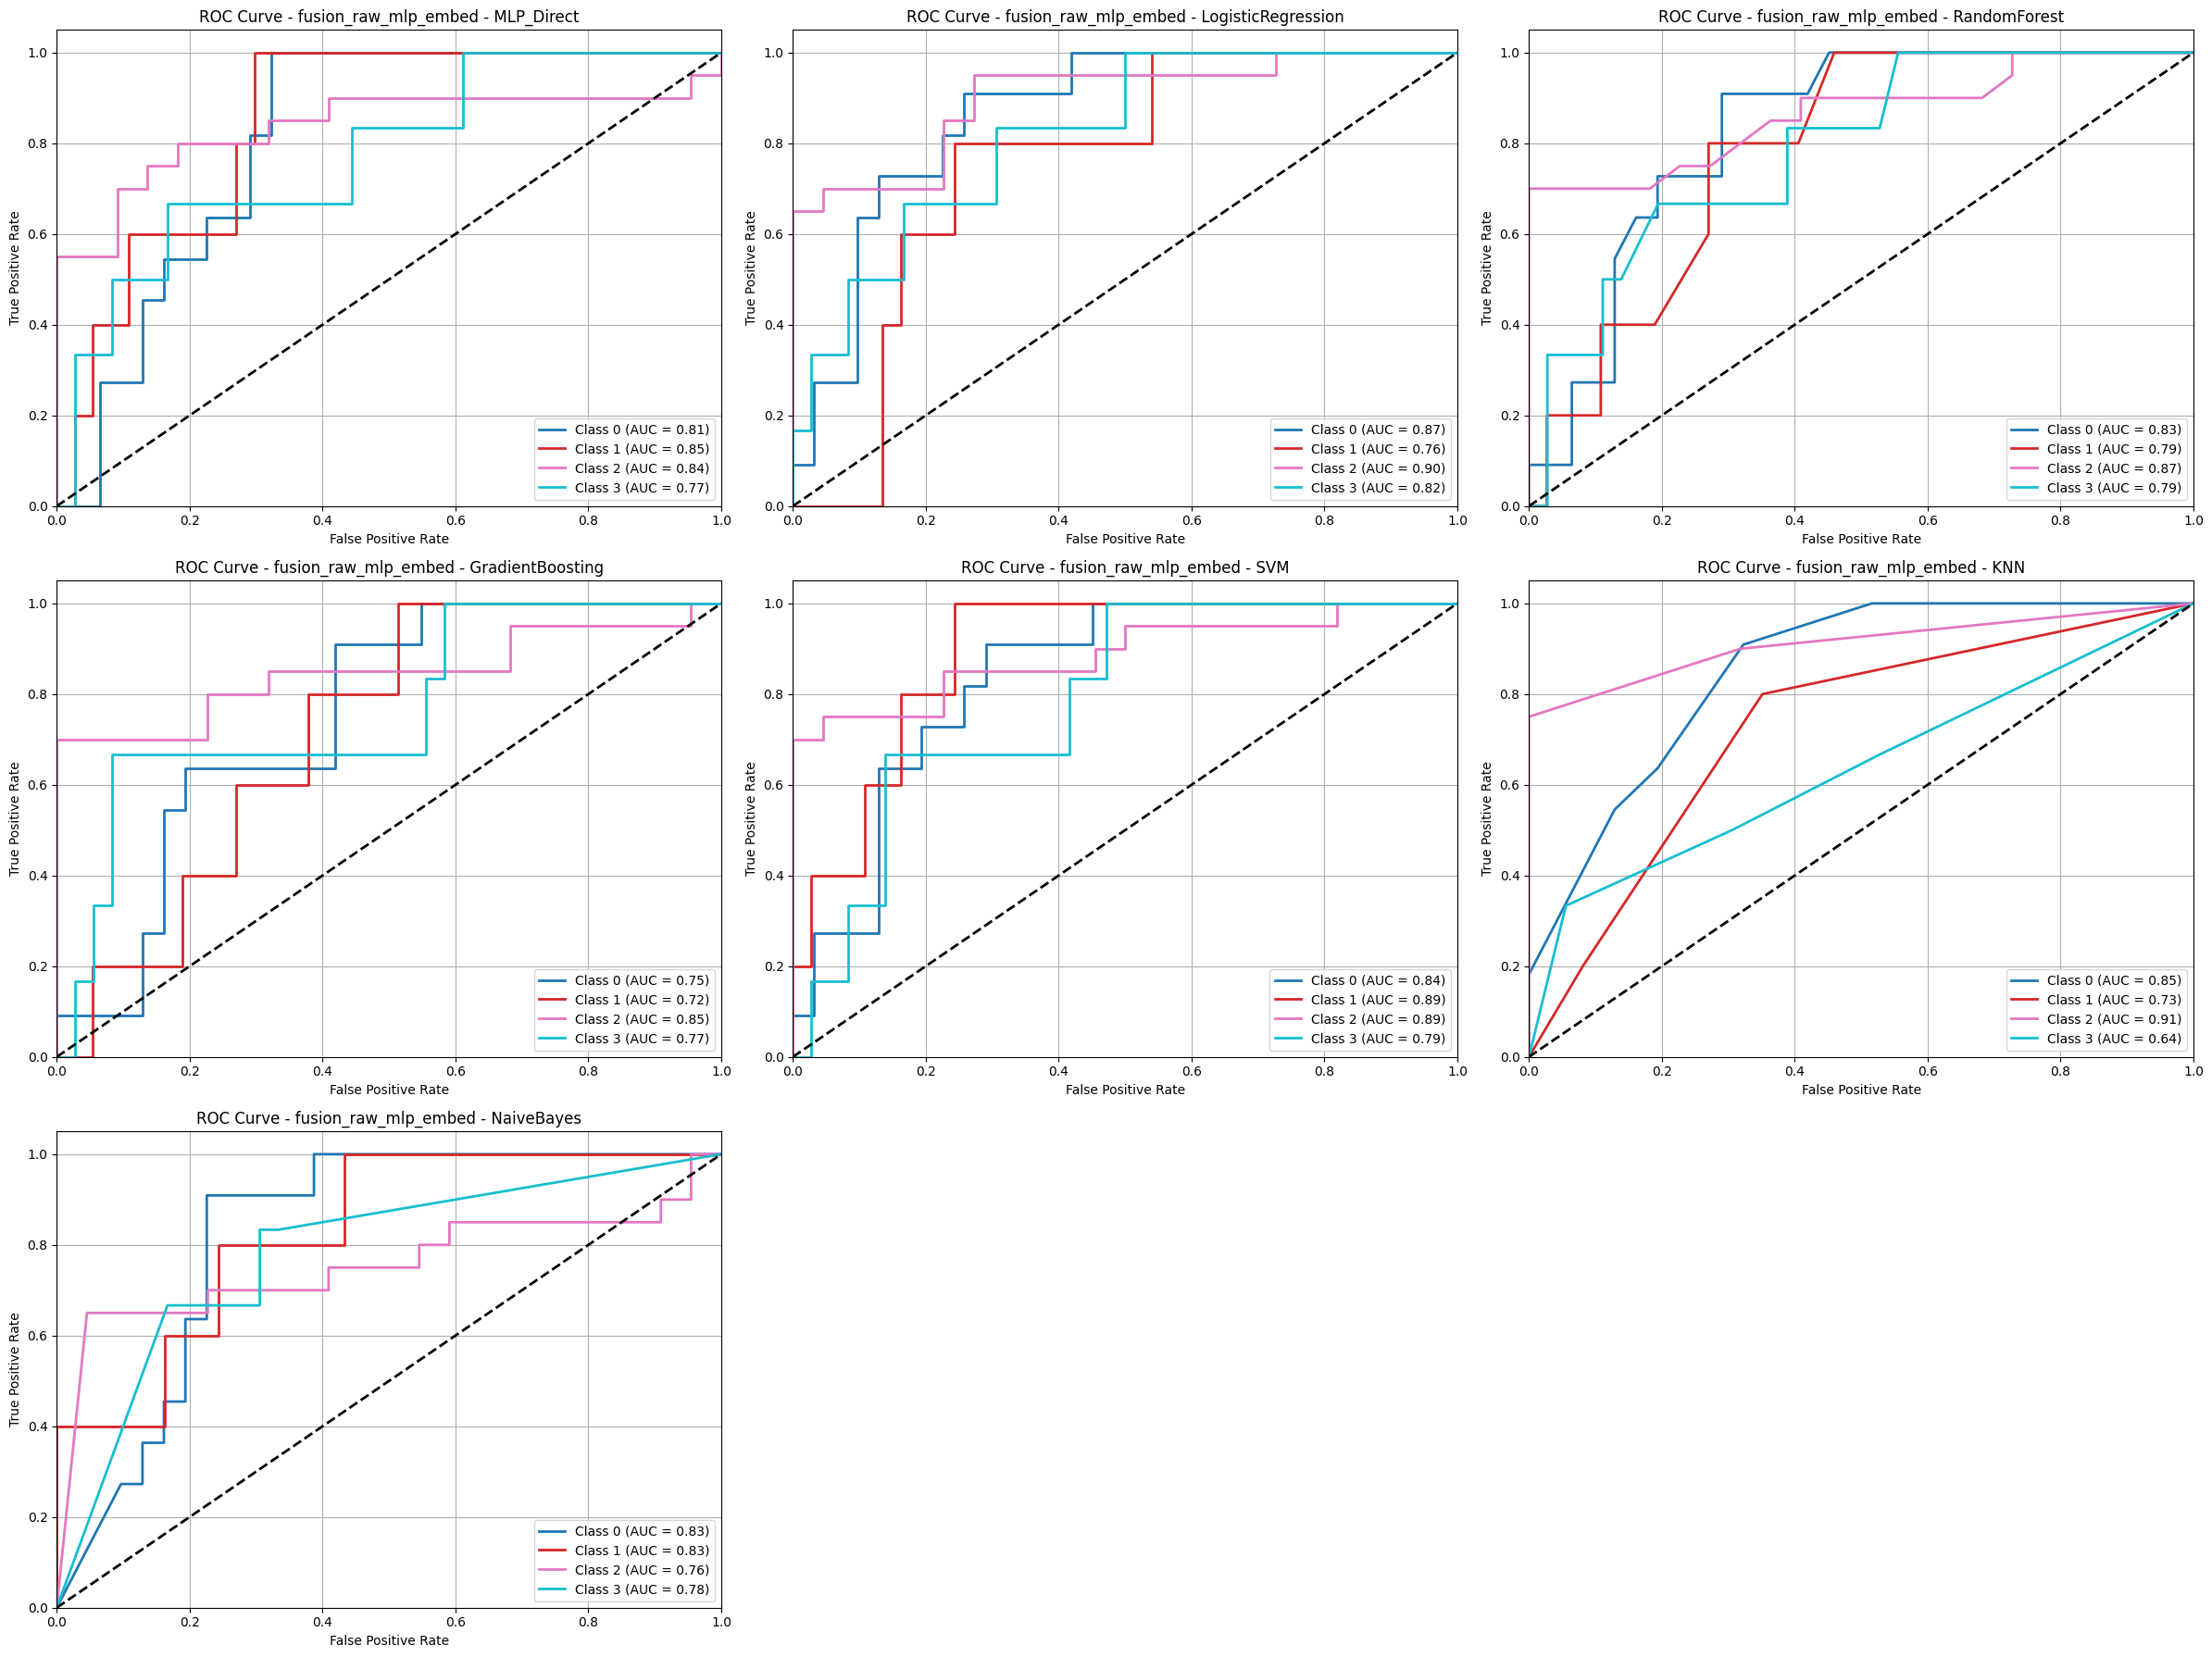

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

n_cols = 3  # Number of images per row
for variant_name, res in results.items():
    y_test_np = res['y_test_np']
    model_type = res['model_type']
    
    if model_type == 'mlp_embed':
        # Handle MLP embedding results (both direct MLP and ML models on embeddings)
        mlp_results = res['mlp_results']
        ml_results = res['ml_results']
        
        # Combine MLP and ML results for plotting
        all_results = {'MLP_Direct': mlp_results}
        all_results.update(ml_results)
        
        model_names = list(all_results.keys())
        n_models = len(model_names)
        n_rows = (n_models + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        plot_idx = 0
        
        for model_name in model_names:
            mres = all_results[model_name]
            y_prob = mres['y_prob']
            if y_prob is None:
                plot_idx += 1
                continue
                
            n_classes = len(np.unique(y_test_np))
            y_test_bin = label_binarize(y_test_np, classes=np.arange(n_classes))
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                
            ax = axes[plot_idx]
            colors = plt.cm.get_cmap('tab10', n_classes)
            
            for i in range(n_classes):
                ax.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
                
            ax.plot([0, 1], [0, 1], 'k--', lw=2)
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC Curve - {variant_name} - {model_name}')
            ax.legend(loc='lower right')
            ax.grid(True)
            plot_idx += 1
            
        # Hide any unused subplots
        for i in range(plot_idx, len(axes)):
            fig.delaxes(axes[i])
        plt.tight_layout()
        plt.show()
    
    else:
        # Handle Autoencoder + ML models results
        ml_results = res['ml_results']
        model_names = list(ml_results.keys())
        n_models = len(model_names)
        n_rows = (n_models + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
        axes = axes.flatten()
        plot_idx = 0
        
        for model_name in model_names:
            mres = ml_results[model_name]
            y_prob = mres['y_prob']
            if y_prob is None:
                plot_idx += 1
                continue
            n_classes = len(np.unique(y_test_np))
            y_test_bin = label_binarize(y_test_np, classes=np.arange(n_classes))
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            ax = axes[plot_idx]
            colors = plt.cm.get_cmap('tab10', n_classes)
            for i in range(n_classes):
                ax.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
            ax.plot([0, 1], [0, 1], 'k--', lw=2)
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'Multiclass ROC Curve - {variant_name} - {model_name}')
            ax.legend(loc='lower right')
            ax.grid(True)
            plot_idx += 1
        # Hide any unused subplots
        for i in range(plot_idx, len(axes)):
            fig.delaxes(axes[i])
        plt.tight_layout()
        plt.show()

In [42]:
# Show summary metrics for all data variants and models, with variant as section header
import pandas as pd
from lifelines.utils import concordance_index

metrics = ['acc', 'f1_macro', 'f1_micro', 'precision', 'recall', 'auc', 'c_index']

for variant_name, res in results.items():
    print(f"\n----------> {variant_name} <-------------")
    y_test_np = res['y_test_np']
    model_type = res['model_type']
    
    if model_type == 'mlp_embed':
        # Handle MLP embedding results (both direct MLP and ML models on embeddings)
        mlp_results = res['mlp_results']
        ml_results = res['ml_results']
        summary_rows = []
        
        # Add MLP direct results
        row = {'Model': 'MLP_Direct'}
        for m in metrics[:-1]:  # all except c_index
            row[m] = mlp_results.get(m, None)
        
        # Compute c-index if possible
        y_prob = mlp_results.get('y_prob', None)
        if y_prob is not None:
            try:
                row['c_index'] = concordance_index(y_test_np, y_prob.max(axis=1))
            except Exception:
                row['c_index'] = None
        else:
            row['c_index'] = None
        summary_rows.append(row)
        
        # Add ML model results on MLP embeddings
        for model_name, mres in ml_results.items():
            row = {'Model': f'MLP_Embed_{model_name}'}
            for m in metrics[:-1]:  # all except c_index
                row[m] = mres[m] if m in mres else None
            # Compute c-index if possible
            y_prob = mres.get('y_prob', None)
            if y_prob is not None:
                try:
                    row['c_index'] = concordance_index(y_test_np, y_prob.max(axis=1))
                except Exception:
                    row['c_index'] = None
            else:
                row['c_index'] = None
            summary_rows.append(row)
            
        summary_df = pd.DataFrame(summary_rows)
        display(summary_df[['Model'] + metrics])
        
    else:
        # Handle Autoencoder + ML models results
        ml_results = res['ml_results']
        summary_rows = []
        for model_name, mres in ml_results.items():
            row = {'Model': model_name}
            for m in metrics[:-1]:  # all except c_index
                row[m] = mres[m] if m in mres else None
            # Compute c-index if possible
            y_prob = mres.get('y_prob', None)
            if y_prob is not None:
                try:
                    row['c_index'] = concordance_index(y_test_np, y_prob.max(axis=1))
                except Exception:
                    row['c_index'] = None
            else:
                row['c_index'] = None
            summary_rows.append(row)
        summary_df = pd.DataFrame(summary_rows)
        display(summary_df[['Model'] + metrics])


----------> fusion_standardized_ae <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,LogisticRegression,0.666667,0.582302,0.666667,0.581360,0.584091,0.880294,0.609137
1,RandomForest,0.547619,0.359596,0.547619,0.346364,0.378030,0.811922,0.543147
2,GradientBoosting,0.500000,0.354211,0.500000,0.364087,0.353030,0.743024,0.604061
3,SVM,0.666667,0.498988,0.666667,0.479365,0.529545,0.856187,0.551607
4,KNN,0.642857,0.587338,0.642857,0.619853,0.592045,0.834661,0.557530
5,NaiveBayes,0.642857,0.588032,0.642857,0.600000,0.629924,0.834814,0.649746



----------> fusion_raw_ae <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,LogisticRegression,0.642857,0.539120,0.642857,0.548026,0.534091,0.859548,0.644670
1,RandomForest,0.690476,0.529762,0.690476,0.506434,0.581439,0.858914,0.577834
2,GradientBoosting,0.619048,0.471933,0.619048,0.461064,0.494318,0.830011,0.590525
3,SVM,0.690476,0.526159,0.690476,0.512500,0.591667,0.865007,0.565144
4,KNN,0.619048,0.434375,0.619048,0.447619,0.475000,0.814741,0.492386
5,NaiveBayes,0.571429,0.508208,0.571429,0.536111,0.535985,0.818603,0.565144



----------> fusion_standardized_mlp_embed <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,MLP_Direct,0.523810,0.246415,0.523810,0.378205,0.295455,0.751756,0.629442
1,MLP_Embed_LogisticRegression,0.595238,0.438205,0.595238,0.436310,0.442424,0.841218,0.590525
2,MLP_Embed_RandomForest,0.642857,0.480159,0.642857,0.492861,0.485985,0.854658,0.554146
3,MLP_Embed_GradientBoosting,0.714286,0.584762,0.714286,0.616541,0.592045,0.815605,0.602369
4,MLP_Embed_SVM,0.642857,0.458153,0.642857,0.440476,0.477652,0.863087,0.546531
5,MLP_Embed_KNN,0.666667,0.573611,0.666667,0.621162,0.577273,0.832241,0.562606
6,MLP_Embed_NaiveBayes,0.476190,0.392465,0.476190,0.395663,0.396970,0.763889,0.648900



----------> fusion_raw_mlp_embed <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,MLP_Direct,0.595238,0.416001,0.595238,0.398485,0.442424,0.817619,0.644670
1,MLP_Embed_LogisticRegression,0.571429,0.431368,0.571429,0.433036,0.440152,0.835326,0.587140
2,MLP_Embed_RandomForest,0.595238,0.423077,0.595238,0.402130,0.452652,0.817915,0.606599
3,MLP_Embed_GradientBoosting,0.595238,0.518612,0.595238,0.515186,0.528030,0.770906,0.632826
4,MLP_Embed_SVM,0.666667,0.502703,0.666667,0.472324,0.558712,0.851001,0.575296
5,MLP_Embed_KNN,0.642857,0.519014,0.642857,0.544079,0.535606,0.781800,0.562606
6,MLP_Embed_NaiveBayes,0.547619,0.477525,0.547619,0.638190,0.492803,0.799742,0.659052
